In [37]:
# Read Dataset
import pandas as pd
df = pd.read_excel('celac.xlsx')
df

,Date,Country,New Cases,New Deaths,Total Cases,Total Deaths
0,2020-03-15,Antigua and Barbuda,1,0,1,0
1,2020-03-21,Antigua and Barbuda,0,0,1,0
2,2020-03-22,Antigua and Barbuda,0,0,1,0
3,2020-03-23,Antigua and Barbuda,0,0,1,0
4,2020-03-24,Antigua and Barbuda,0,0,1,0
...,...,...,...,...,...,...
2991,2020-06-06,Venezuela,58,0,2145,20
2992,2020-06-07,Venezuela,171,2,2316,22
2993,2020-06-08,Venezuela,61,0,2377,22
2994,2020-06-09,Venezuela,96,0,2473,22


In [38]:
#Dataprocessing
df.isnull().values.any()

False

In [39]:
#Getting list of countries
countries = df['Country'].drop_duplicates()
countries

0                    Antigua and Barbuda
83                             Argentina
179                              Bahamas
264                             Barbados
349                               Belize
428                              Bolivia
518                                Chile
616                             Colombia
708                           Costa Rica
803                                 Cuba
891                             Dominica
971                   Dominican Republic
1125                             Ecuador
1283                         El Salvador
1367                             Grenada
1447                           Guatemala
1535                              Guyana
1623                               Haiti
1706                            Honduras
1795                             Jamaica
1885                              Mexico
2040                           Nicaragua
2124                              Panama
2217                            Paraguay
2308            

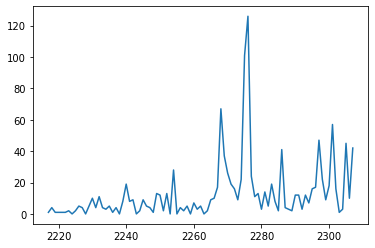

In [40]:
# New cases in Paraguay
casos_paraguay = df[df['Country']=="Paraguay"]
casos_paraguay["New Cases"].plot()

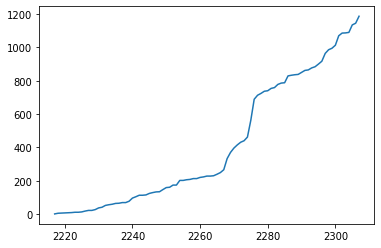

In [41]:
# Total cases in Paraguay
casos_paraguay["Total Cases"].plot()

Total Cases:  666396
Total Deaths:  30811


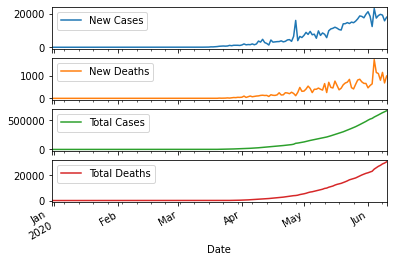

In [42]:
# Cases of entire Latin America and Caribbean
grouped = df.groupby("Date").sum()
grouped.plot(subplots=True) 
print("Total Cases: ", grouped["Total Cases"][-1])
print("Total Deaths: ", grouped["Total Deaths"][-1])

In [43]:
#Getting only Latam countries data

members = pd.read_excel('members of CELAC.xlsx')
latam = members["Spanish"].str.replace('\xa0', '')
latam_cases = df[df['Country'].isin(latam)]
latam_cases

,Date,Country,New Cases,New Deaths,Total Cases,Total Deaths
83,2020-03-04,Argentina,1,0,1,0
84,2020-03-06,Argentina,1,0,2,0
85,2020-03-07,Argentina,6,0,8,0
86,2020-03-08,Argentina,1,1,9,1
87,2020-03-09,Argentina,3,0,12,1
...,...,...,...,...,...,...
2991,2020-06-06,Venezuela,58,0,2145,20
2992,2020-06-07,Venezuela,171,2,2316,22
2993,2020-06-08,Venezuela,61,0,2377,22
2994,2020-06-09,Venezuela,96,0,2473,22


Total Cases:  661377
Total Deaths:  30700


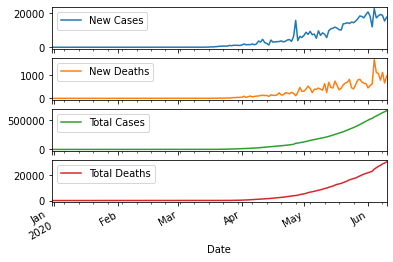

In [44]:
# Cases in Latam

grouped_latam = latam_cases.groupby("Date").sum()
grouped_latam.plot(subplots=True) 
print("Total Cases: ", grouped_latam["Total Cases"][-1])
print("Total Deaths: ", grouped_latam["Total Deaths"][-1])

In [45]:
# Getting only Caribbean countries data

caribbean_cases = df[~df['Country'].isin(latam)]
caribbean_cases

,Date,Country,New Cases,New Deaths,Total Cases,Total Deaths
0,2020-03-15,Antigua and Barbuda,1,0,1,0
1,2020-03-21,Antigua and Barbuda,0,0,1,0
2,2020-03-22,Antigua and Barbuda,0,0,1,0
3,2020-03-23,Antigua and Barbuda,0,0,1,0
4,2020-03-24,Antigua and Barbuda,0,0,1,0
...,...,...,...,...,...,...
2815,2020-06-06,Trinidad and Tobago,0,0,117,8
2816,2020-06-07,Trinidad and Tobago,0,0,117,8
2817,2020-06-08,Trinidad and Tobago,0,0,117,8
2818,2020-06-09,Trinidad and Tobago,0,0,117,8


Total Cases:  5019
Total Deaths:  111


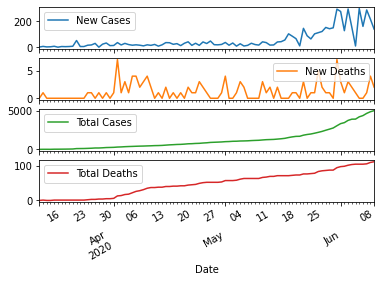

In [46]:
# Cases in Caribbean

grouped_caribbean = caribbean_cases.groupby("Date").sum()
grouped_caribbean.plot(subplots=True) 
print("Total Cases: ", grouped_caribbean["Total Cases"][-1])
print("Total Deaths: ", grouped_caribbean["Total Deaths"][-1])

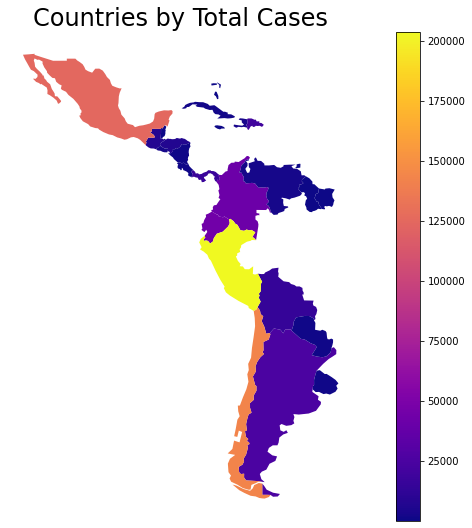

In [47]:
# Building choropleth map of total cases in all countries

!python -m pip install geopandas > /dev/null
!python -m pip install descartes > /dev/null
import geopandas

mapa = geopandas.read_file('custom.geo.json').rename(columns={"adm0_a3": "iso3"})
iso = pd.read_csv('iso.csv')
last_registers = df[df['Date'] == '2020-06-10']
with_iso = pd.merge(last_registers, iso, how='left', left_on='Country', right_on='name')
mapa = mapa.merge(with_iso, on="iso3")

#plot merged file. use dropna to remove any country with no revenue value
ax = mapa.plot(column='Total Cases', cmap =    
                                'plasma', figsize=(15,9),   
                                  k=3, legend =  
                                  True);

#add title to the map
ax.set_title('Countries by Total Cases', fontdict= 
            {'fontsize':24})
#remove axes
ax.set_axis_off()
#ax.get_figure()

In [48]:

# Dataset selection
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

dataset = grouped.reset_index()
trainX, testX, trainY, testY = train_test_split(np.float32(dataset.index), np.float32(dataset["Total Cases"]))



MSE:  35788344.0
RMSE:  5982.336
RRSE:  0.036180798
Accuracy:  96.38192020356655 %


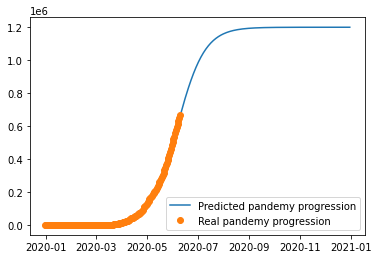

In [49]:
# Model fitting and visualization

from scipy import optimize

def logistic_function(x: float, h: float, w: float, b: float):
  return h / (1.0 + np.exp(-w * (x - b)))

params, _ = optimize.curve_fit(logistic_function, trainX, trainY)
mse = np.sum(np.square(testY - logistic_function(testX, *params))/len(testY))
rmse = np.sqrt(mse)
rrse = np.sqrt(np.sum(np.square(testY - logistic_function(testX, *params))) / np.sum(np.square(testY - np.mean(testY))))
acc = (1 - rrse) * 100
x = np.arange(0, 367)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("RRSE: ", rrse)
print("Accuracy: ", acc, "%")
plt.plot(pd.date_range(start="2019-12-31", end="2020-12-31"), logistic_function(x, *params), label='Predicted pandemy progression')
plt.plot(dataset["Date"], dataset["Total Cases"], "o", label='Real pandemy progression')
plt.legend()
plt.show()


In [50]:

ranking = last_registers.sort_values("Total Cases", ascending=False).reset_index()
ranking

,index,Date,Country,New Cases,New Deaths,Total Cases,Total Deaths
0,2402,2020-06-10,Peru,4040,167,203736,5738
1,615,2020-06-10,Chile,3913,19,142759,2283
2,2039,2020-06-10,Mexico,4199,596,124301,14649
3,1282,2020-06-10,Ecuador,539,48,43917,3690
4,707,2020-06-10,Colombia,1359,64,42078,1372
5,178,2020-06-10,Argentina,1141,24,24748,717
6,1124,2020-06-10,Dominican Republic,289,5,20415,544
7,2216,2020-06-10,Panama,379,5,17233,403
8,517,2020-06-10,Bolivia,695,12,14644,487
9,1534,2020-06-10,Guatemala,364,22,7866,289


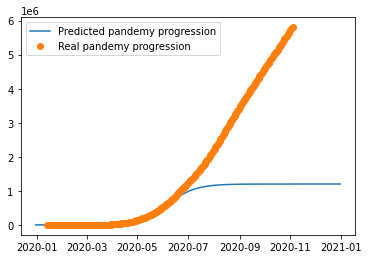

In [51]:
from datetime import datetime

worlddata = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
celac_actual = worlddata[worlddata["iso_code"].isin(with_iso["iso3"])]
groupped_celac = celac_actual[["date", "total_cases"]].dropna().groupby("date").sum()
groupped_celac.index = pd.to_datetime(groupped_celac.index)
x = x = np.arange(0, 367)
plt.plot(pd.date_range(start="2019-12-31", end="2020-12-31"), logistic_function(x, *params), label='Predicted pandemy progression')
plt.plot(groupped_celac.index, groupped_celac["total_cases"], "o", label='Real pandemy progression')
plt.legend()


In [52]:
trainX, testX, trainY, testY = train_test_split(np.float32(groupped_celac.reset_index().index), np.float32(groupped_celac["total_cases"]))
params_new, _ = optimize.curve_fit(logistic_function, trainX, trainY)

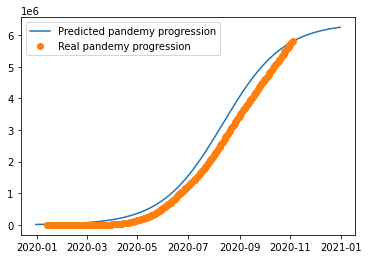

In [53]:
plt.plot(pd.date_range(start="2019-12-31", end="2020-12-31"), logistic_function(x, *params_new), label='Predicted pandemy progression')
plt.plot(groupped_celac.index, groupped_celac["total_cases"], "o", label='Real pandemy progression')
plt.legend()